# Super organised modular notebook


## Imports and installation

You can install the packages needed using the following command `pip install -r requirements.txt`  where the file contains the following:

<div class="alert alert-block alert-info">

aiohttp==3.9.5\
asyncio==3.4.3\
igraph\
requests\
py4cytoscape==1.9.0\
pandas\
tqdm==4.66.2\
numpy
</div>

Please note that Cytoscape has to be installed and open on your machine for visualisation to work.

In [126]:
# General packages
import pandas as pd         
import os
from tqdm import tqdm       
import pickle
import numpy as np
from datetime import datetime, timedelta
import glob
import sys
import matplotlib.pyplot as plt


# define format, and set parameters for time, TODO: rm?  
date_format = "%Y_%m_%d_%H_%M" 
current_date = datetime.now().strftime(date_format)
last_week_date = (datetime.now() - timedelta(days=7)).strftime(date_format)



# Project specific packages
import aiohttp              # Used for aggregating requests into single session
import asyncio              # -"-
import nest_asyncio         # For jupyter asyncio compatibility 
nest_asyncio.apply()        # Automatically takes into account how jupyter handles running event loops

# TODO: import jsonpath_ng.ext      # More efficient json processing look into if actually computationally more efficient 
import igraph               # Used to create te citationa graph 
import requests             # For single API requests 

# workflow parsing 
from cwl_utils.parser import load_document_by_uri, save # for workflow parsing 
from ruamel import yaml



# Visualisation 
import py4cytoscape as p4c  # Cytoscape for visualisation of the citaton graph, 
                            # note that Cytoscape has to be installed and open on your machine for visualisation to work

Check that the packages are installed and functional 

In [25]:
print("igraph version:", igraph.__version__)
try: 
    dir(p4c)
    p4c.cytoscape_ping() 
    print("Cytoscape version:",p4c.cytoscape_version_info()['cytoscapeVersion'])    
except:
    print ("Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!")


igraph version: 0.11.4
You are connected to Cytoscape!
Cytoscape version: 3.10.2


## Downloading data 

In [26]:
# format: 
"""

    Function description 
    
    Parameters
    ----------
    name : type
        description
"""

'\n\n    Function description \n    \n    Parameters\n    ----------\n    name : type\n        description\n'

In [27]:
async def fetch_biotools_page(session, url):
    """ 
    Sync the bio.tools (page) requests so they are all made in a single session 

    Parameters
    ----------
    session : aiohttp.client.ClientSession object
        session object for package aiohttp
    url : str
        url for request
    """
    
    async with session.get(url) as response:
        return await response.json()

In [41]:
async def get_biotools_metadata(topicID="topic_0121"):  # TODO: I removed format. Check if there is any reason to have it 
                                                        # TODO: should add parameter for optional forced retrieval - even if csv file, still recreate it 
                                                        # TODO: Currently no timing - add tracker
    """
    Fetches metadata about tools from bio.tools, belonging to a given topicID and returns as a dataframe.
    If a CSV file already exists load the dataframe from it. 

    Parameters
    ----------
    topicID : str TODO: make this a int instead? why am I writing topic? 
        The ID to which the tools belongs to, ex. "Proteomics" or "DNA" as defined by 
        EDAM ontology (visualisation: https://edamontology.github.io/edam-browser/#topic_0003)

    
    """

    date_format = "%Y%m%d"

    pattern = f'biotools_metadata_{topicID}*'
    matching_files = glob.glob(pattern)
    if matching_files:
        matching_files.sort(key=os.path.getmtime)
        csv_filename = matching_files[-1]
        
        # Check if file older than a week
        file_date = datetime.strptime(csv_filename.split('_')[-1].split('.')[0], date_format)
        if file_date < datetime.now() - timedelta(days=7):
            print("Old datafile. Updating...")
        else:
            print("Bio.tools data loaded from existing CSV file.")
            df = pd.read_csv(csv_filename)
            return df
    else:
        print("No existing bio.tools CSV file. Downloading data.") 

    # Define the CSV filename
    #csv_filename = f'biotools_metadata_{topicID}_{datetime.now().strftime(date_format)}.csv' 



    
    # TODO: should filepath/name be allowed to be configurable?
    # then the following could be a separate function called by this one, or is this very inefficient?
    # TODO: should place files created in a folder named for each run

    all_tool_data = [] # TODO: predefine the length, means one more request 

    # start at page 1 
    page = 1 

    # requests are made during single session
    async with aiohttp.ClientSession() as session: 
        while page:

            # send request for tools on the page, await further requests 
            biotools_url = f'https://bio.tools/api/t?topicID=%22{topicID}%22&format=json&page={page}'
            biotool_data = await fetch_biotools_page(session, biotools_url)
            

            # TODO: Do I need to check? what happens if no response for page == 1? Maybe try/except instead
            # Checking if there are any tools, if 
            if 'list' in biotool_data: 
                biotools_lst = biotool_data['list']


                for tool in biotools_lst:
                    name = tool.get('name') 
                    publication = tool.get('publication')
                    topic = tool.get('topic')
                    # TODO: decide whether we even want this information since it would only be used for visualisation and possibly teh multitopic graph 

                    # TODO: if no pmid, use doi converter 
                    # TODO: Download primary (using jasonpatg-ng), 
                    if name and publication and publication[0].get('pmid') and topic and topic[0].get('term'): 
                        all_tool_data.append({ #predefine, since max length == nr_tools, then need to define this earlier
                            'name': name,
                            'pmid': str(publication[0]['pmid']), # making sure they are all strings
                            'topic': topic[0]['term']
                        })

                page = biotool_data.get('next')
                if page: # else page will be None and loop will stop 
                    page = page.split('=')[-1] # only want the page number 
            else: 
                print(f'Error while fetching tool names from page {page}')
                break

    # Convert list of dictionaries to dataframe
    df = pd.DataFrame(all_tool_data)
    # Save dataframe to file
    df.to_csv(csv_filename, index=False)

    # If there were any pages, check how many tools were retrieved and how many tools had pmids
    if biotool_data: 
        nr_tools = int(biotool_data['count']) 
        print(f'Found {len(all_tool_data)} out of a total of {nr_tools} tools with PMIDS.')

    return df

In [29]:
def europepmc(article_id, format='JSON', source='MED', page=1, page_size=1000):   # TODO: replace own wrapper with recommendation? https://github.com/ML4LitS/CAPITAL/tree/main
                                                                                # TODO: call output="idlist" immidiately? then we have no metadata but we dont use that anyways!
    """ 
    Downloads pmids for the articles citing the given article_id, returns list of citation pmids (PubMed IDs)
        
    Parameters
    ----------
    article_id : str # TODO: int? 
        pmid, PubMed ID, for a given article.
    source: str
        source ID as given by the EuropePMC API documentation: https://europepmc.org/Help#contentsources 

    page, int, default == 1
        determines where to start looking TODO: remove this, why would you not start at 1? 

    pagesize, int, default 1000 max 1000
        determines number of results per page
    
    """ 

    # create a url with the given requirements according to the EuropePMC API synthax and query the API
    base_url = f'https://www.ebi.ac.uk/europepmc/webservices/rest/{source}/{article_id}/citations?page={page}&pageSize={page_size}&format={format}'
    result = requests.get(base_url)

    # Return all citations, given the query was accepted
    # TODO: jsonpath-ng
    if result.ok:
        return result.json()['citationList']['citation']
    else:
        print('Something went wrong') # TODO: better error message. Try/except? 


## Graph generation

The function reate_citation_network can be called to create or load the cocitation network

In [34]:
#TODO: all of the descriptions - Where do I put default value? 

def create_citation_network(topicID="topic_0121", testSize=None, randomSeed=42, loadData=True, filePath='', saveFiles=True): # TODO: I just threw  code into this function- improve
    
    """
    Creates a citation network given a topic and returns a graph and the tools included in the graph

        
    Parameters
    ----------
    topicID : str, default "topic_0121" (proteomics) TODO: int? 
        The ID to which the tools belongs to, ex. "Proteomics" or "DNA" as defined by 
        EDAM ontology (visualisation: https://edamontology.github.io/edam-browser/#topic_0003)

    testSize : int or None, default None
        Determines the number of tools included in the citation graph.

    randomSeed : int, default 42
        Specifies what seed is used to randomly pick tools in a test run. 
    
    loadData : Boolean, default True
        Determines if already generated graph is loaded or if it is recreated.
    
    filePath : str  TODO: add filepath 
        Path to already generated graph

    saveFiles : Boolean, default True
        Determines if newly generated graph is saved. 

    """
    # Retrieve the data 
    # run the asynchronous function for single session requests 
    result = asyncio.run(get_biotools_metadata(topicID=topicID)) 
    pmids = result['pmid'].tolist() # should I use numpy for all my lists? 

    # Randomly picks out a subset of the pmids
    if testSize:   
        print(f"Creating test-cocitation network of size {testSize}. Random seed is {randomSeed}.")
        np.random.seed(randomSeed)
        pmids = np.random.choice(pmids,testSize)
    else:
        testSize = '' # temp for the creation of files, so they dotn ahve none in name 
    
    # Edge creation 
    # Load previously created data or recreate it
    if loadData: # TODO: pickle mayebe is not the way to go in future? 
        
        if os.path.isfile(f'edges{testSize}.pkl') and os.path.isfile(f'graph{testSize}.pkl') and os.path.isfile(f'included_tools{testSize}.pkl'): # should give option to specify these names
            print("Loading saved graph")
            with open(f'edges{testSize}.pkl', 'rb') as f:
                unq_edges = pickle.load(f) # should be unique ones right 
            with open(f'graph{testSize}.pkl', 'rb') as f:
                G = pickle.load(f) 
            with open(f'included_tools{testSize}.pkl', 'rb') as f:
                included_tools = pickle.load(f) 
        else:
            print(f"Files not found. Please check that 'edges{testSize}.pkl', 'graph{testSize}.pkl' and 'included_tools{testSize}.pkl' are in your current directory and run again. Or set loadData = False, to create the files. ")
            return 
   
    else:
        # edge creation using europepmc
        print("Downloading citation data from Europepmc.")
        
        # this is to create a list of the tools that actually had citations, otherwise they are not included in the graph. 
        included_tools = []  # TODO: is there a smarter way of generating the included_tools list? 
        edges = []

        # Get citations for each tool, and generate edges between them. 
        for pmid in tqdm(pmids, desc="Processing PMIDs"): 
            pmid = str(pmid) # EuropePMC requires str            
    
            citations = europepmc(pmid, page_size=1000)
            for citation in citations:
                edges.append((pmid, str(citation['id']))) # TODO: this is the wring way around? shoudl be citation to pmid, no? 
                if pmid not in included_tools:
                    included_tools.append(pmid) 
        
        print("Creating citation graph using igraph.")
        
        # Finding unique edges by converting list to a set (because tuples are hashable) and back to list.
        # TODO: maybe not super efficient? 
        unq_edges =  list(set(edges)) 
        print(f"{len(unq_edges)} unique out of {len(edges)} edges total!")

        # Creating a directed graph with unique edges
        G = igraph.Graph.TupleList(unq_edges, directed=True)

        # TODO: its starting to get messy man
        # Removing disconnected vertices (that are not tools) that do not have information value for the (current) metric
        print("Removing citations with degree less or equal to 1 (Non co-citations).")
        vertices_to_remove = [v.index for v in G.vs if v.degree() <= 1 and v['name'] not in included_tools] 
        G.delete_vertices(vertices_to_remove)
        vertices_to_remove = [v.index for v in G.vs if v.degree() == 0 ] # second run to remove the copletely detatched ones after first run sicne they wont give info anyways. 
        G.delete_vertices(vertices_to_remove) # This will remove isolated tools as well 

        # Updating included_tools to only contain lists that are in the graph  
        included_tools = [tool for tool in included_tools if tool in G.vs['name']] # TODO: since I am doing this anyways I could do it with pmids directly and not generate the included_tools list earier?


        # Saving edges, graph and tools included in the graph 
        if saveFiles:
            print(f"Saving data to 'edges{testSize}.pkl', 'graph{testSize}.pkl' and 'included_tools{testSize}.pkl'.") # sould make these filenames dynamic
            # and save them 
            #Do this nicer later? 
            with open(f'edges{testSize}.pkl', 'wb') as f:
                pickle.dump(unq_edges, f)

            with open(f'graph{testSize}.pkl', 'wb') as f:
                pickle.dump(G, f)

            with open(f'included_tools{testSize}.pkl', 'wb') as f:
                pickle.dump(included_tools, f)    

    # returns a graph and the pmids of the tools included in the graph (tools connected by cocitations)
    return G, included_tools 


## The metric

Create the cocitation network specifying if you want to load existing data, run on a smaller test set etc.  

In [54]:
# G, included_tools = create_citation_network(testSize=100, loadData=False)

#TODO: filepath for input files! 
# G, included_tools = create_citation_network()


# G, included_tools = create_citation_network(loadData=False) # took 20 min for full graph, wtf?

G, included_tools = create_citation_network()

### Download workflow data


<div class="alert alert-block alert-warning">
<b>OBS:</b> This is not yet implemented. Currently drawing random tools to simulate workflows
</div>

In [63]:
# TODO: download workflows

# TODO: improve randomisation to have sequential networks

# number of edges in the workflow

def radnomise_workflow(num_pairs = 3):
    workflow_pairs = []
    while len(workflow_pairs) < num_pairs:
        article1 = np.random.choice(included_tools)
        article2 = np.random.choice(included_tools)
        if article1 != article2:  # Ensure article1 and article2 are different
            workflow_pairs.append((article1, article2))

    workflow_tools = np.unique([element for tuple in workflow_pairs for element in tuple])
    return workflow_pairs, workflow_tools
    # print( "Tools in pseudo WF:", workflow_tools)
    # # Print the generated pairs
    # print("Generated workflow pairs (WF edges):")
    # for pair in workflow_pairs:
    #     print(pair)

In [61]:
def parse_workflows(cwl_file):
    # Import CWL Object
    cwl_obj = load_document_by_uri(cwl_file)

    # Extract edges from CWL object
    edges = []
    for step in cwl_obj.steps:
        step_id = step.id.split("#")[-1]
        for input_param in step.in_:
            if input_param.source:
                source_step_id = input_param.source.split('/')[-1].split("#")[-1]
                edges.append((source_step_id, step_id))
        for output_param in step.out:
            edges.append((step_id, output_param.split("/")[-1]))

    # Extract pairwise connections between tools
    pairwise_connections = set()
    for source, target in edges:
        if "_out_" in source:
            tool_id = target.split("_")[0]
            for next_target, next_source in edges:
                if next_source == source:
                    pairwise_connections.add((tool_id, next_target.split("_")[0]))

    # Read CSV file containing tool information
    csv_filename = 'biotools_metadata_topic_0121_20240429.csv'
    f = pd.read_csv(csv_filename)

    # Retrieve PMID values for pairwise connections, this should be bio.tools ids instead? 
    new_edges = []
    for edge in pairwise_connections:
        source_pmid = f.loc[f['name'] == edge[0], 'pmid'].values[0] if len(f.loc[f['name'] == edge[0], 'pmid']) > 0 else None # neme in small letters too? 
        target_pmid = f.loc[f['name'] == edge[1], 'pmid'].values[0] if len(f.loc[f['name'] == edge[1], 'pmid']) > 0 else None
        if source_pmid is not None and target_pmid is not None:
            new_edges.append((str(source_pmid), str(target_pmid)))

    # Print new edges
    workflow_tools = np.unique([element for tuple in new_edges for element in tuple])

    return new_edges, list(workflow_tools)

    # # Construct graphs
    # G1 = igraph.Graph.TupleList(edges, directed=True)
    # G2 = igraph.Graph.TupleList([(target, source) for source, target in edges], directed=True) # rotated
    # G3 = igraph.Graph.TupleList(pairwise_connections, directed=True)
    # G4 = igraph.Graph.TupleList(new_edges, directed=True)



In [64]:
cwl_file = "../workflows/candidate_workflow_2.cwl"

workflow_pairs, workflow_tools = parse_workflows(cwl_file) # TODO: more than one at a time 

rand_workflow_pairs, rand_workflow_tools = radnomise_workflow(num_pairs = 3)

print(workflow_pairs, rand_workflow_pairs)

[('14632076', '23148064'), ('29400476', '23148064'), ('29400476', '14632076')] [('34882763', '21751374'), ('17768164', '36622218'), ('37010503', '31768063')]


could add visualisation of the workflows and the original workflows. 

In [52]:
# static for testing 
workflow_pairs = [('29400476', '14976030'), ('29400476', '14632076'), ('14632076', '14976030')]
workflow_tools = list(np.unique([element for tuple in workflow_pairs for element in tuple]))


### Calculate metric

<div class="alert alert-block alert-warning">
<b>OBS:</b> This is a simple placeholder implementation of a metric
</div>

In [13]:
def comet(graph, workflows): # cocitation metric 

    """
    Calculates the cocitation  metric for a given workflow and a given cocitation graph
    
    Parameters
    ----------
    graph : igraph.Graph
        Graph generated by igraph
    workflow, list of tuples with pairs of strings TODO: how do I write this? does it matter I wont have this format later anyways? 
        List of tuples of strings corresponding to the edges in the workflow. 

    """
    # List to  collect pairwise scores
    score_list = [] # TODO: can predefine the list length, does not matter this is temporary?

    for pair in workflows:
        cocite_score = 0
        neighbors_of_first = set(graph.neighbors(pair[0]))
        neighbors_of_second = set(graph.neighbors(pair[1]))

        # Count number of common neighbours
        common_neighbors = neighbors_of_first.intersection(neighbors_of_second)
        cocite_score = len(common_neighbors)
        score_list.append(cocite_score)

    # Then sum the scores or perform any other desired calculation
    # now normalising by WF length
    # maybe call this one "support", since that is basically what we have. 

    return sum(score_list)/len(score_list), score_list


In [46]:
metric_score, raw_results = comet(G, workflow_pairs)

print(raw_results)

print(f"Total cocitation score for workflow {workflow_pairs} is {metric_score}.")


[4, 5, 47]
Total cocitation score for workflow [('29400476', '14976030'), ('29400476', '14632076'), ('14632076', '14976030')] is 18.666666666666668.


### Evaluate results 

Below I am comparing the workflows from workflomics, to completely randomly drawn tools from the bioinformatics topic 

In [108]:
workflomics_tools = {"Comet":"23148064" , "PeptideProphet":"12403597" ,"ProteinProphet":"14632076" ,"StPeter":"29400476" ,"mzRecal":"33538780" ,
                     "idconvert":"23051804" ,"msconvert":"23051804" ,"GOEnrichment":None ,"gProfiler":'27098042' ,"ms_amanda":'24909410' ,
                       "msfragger":'28394336' , "protXml2IdList":None }
# some of them do not have 

In [ ]:
workflows = []
rand_workflows = []

for i in range(1, 13):
    cwl_file = f"../workflows/candidate_workflow_{i}.cwl"
    try:
        workflow_pairs, workflow_tools = parse_workflows(cwl_file) # TODO: more than one at a time 
        workflows.append(workflow_pairs)

        rand_workflow_pairs, rand_workflow_tools = radnomise_workflow(num_pairs = len(workflow_tools)) # making sure they all have the same amount of tools 
        rand_workflows.append(rand_workflow_pairs)
    except:
        continue 


print(workflows, rand_workflows) # wooh thats ineffeicient 

In [109]:
scores=[]
rand_scores =[]

for i in range(len(workflows)):
    metric_score, raw_results = comet(G, workflows[i])
    rand_metric_score, rand_raw_results = comet(G, rand_workflows[i])

    scores.append(metric_score)
    rand_scores.append(rand_metric_score)
    
print(rand_scores, scores)

[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 1.25] [18.666666666666668, 27.0, 290.5, 324.5, 18.666666666666668, 164.5, 16.4, 27.0, 58.5, 162.75]


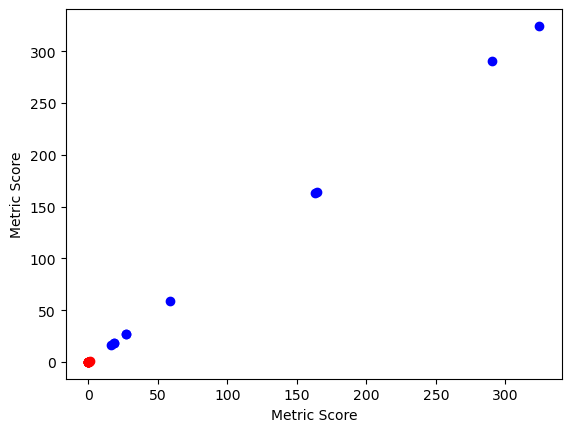

In [99]:

plt.scatter(scores, scores, color='blue', label='Non-random')
plt.scatter(rand_scores, rand_scores, color='red', label='Random')

plt.xlabel('Metric Score')
plt.ylabel('Metric Score')
plt.show()


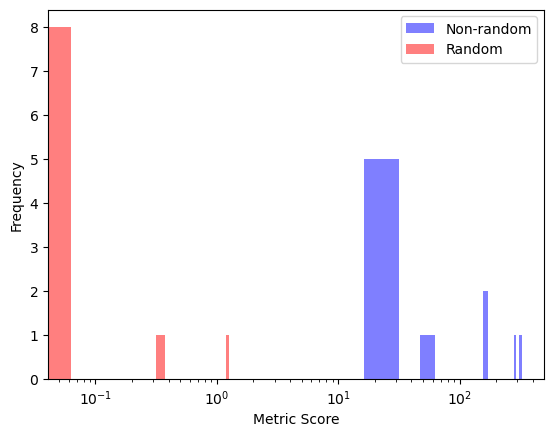

In [125]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()

ax.set_xscale('log') # because otherwise not showing up in same plot for some reason

# Show plot
plt.show()


## Visualisation


Using cytoscape to visualise the network (Alma add colouring of the workflow too)

In [53]:

import time # TODO: i switched to datetime, fix this later 
t = time.localtime()
current_time = time.strftime("%Y_%m_%d_%H_%M", t)


p4c.create_network_from_igraph(G, f"Cocitations_Size{len(included_tools)}_{current_time}")


print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass(included_tools, "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass(included_tools, 100)  # remember it cannot be a np.array, just a list argh 

# colour the tools in the workflow 
p4c.set_node_color_bypass(workflow_tools, "#2F739A")  # they should be gradually coloured later maybe, sequentially
p4c.set_node_size_bypass(workflow_tools, 200)  # remember it cannot be a np.array, just a list argh 


Applying default style...
Applying preferred layout
Styling graph
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

''